# A journey into Convolutional Neural Network visualization 
*Francesco Saverio Zuppichini*
There is one famous urban legend about computer vision. Around the 80s, the US military wanted to use neural networks to automatically detect camouflaged enemy tanks. They took a number of pictures of trees without tanks and then pictures with the same trees with tanks behind them.
The results were impressive. So impressive that the army wanted to be sure the net had correctly generalized. They took new pictures of woods with and without tanks and they showed them again to the network. This time, the model performed terribly, it was not able to discriminate between pictures with tanks behind woods and just trees.It turned out that all the pictures without tanks were taken on a cloudy day while the ones with tanks on a sunny day! In reality, the network learn to recognize the weather, not the enemy tanks.

## Nosce te ipsum

With this article, we are going to see different techniques to *understand* what it is going on inside a Convolutional Neural Network to avoid making the same US' army mistake.
 
We are going to use [Pytorch](https://pytorch.org/). All the code can be found [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-). Most of the visualizations were developed from scratch, however, some inspiration and parts were taken from [here](https://github.com/utkuozbulak/pytorch-cnn-visualizations/tree/master/src).

We will first introduce each technique by briefly explain it and making some example and comparison between different classic computer vision models, `alexnet`, `vgg16` and `resnet`. Then we will try to better understand a model used in robotics to predict the local distance sensor using only the frontal camera's images.

Our goal is not to explain in detail how each technique works since this is already done extremely well by each paper, but to use them to help the reader visualize different model with different inputs to better understand and highlight what and how different models react to a given input.

Later on, we show a workflow in which we utilize some of the techniques you will learn in this journey to test the robustness of a model, this is extremely useful to understand and fix its limitations.

The curios reader could further improve is understand by looking and the [source code](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/tree/master/visualisation/core) for each visulisation and by reading the references.

# Preambula

**Disclaimer** I am not a fan of jupyter. So apologize in advance if there are some warnings in the outputs and some figures are not well made

Let's start our journey by selecting a network. Our first model will be the old school `alexnet`. It is already available in the ` torchvision.models` package from Pytorch

In [2]:
%load_ext autoreload
%autoreload 2


In [3]:
from torchvision.models import *
from visualisation.core.utils import device

model = alexnet(pretrained=True).to(device)
print(model)

AlexNet(
  (features): Sequential(
    (0): Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2))
    (1): ReLU(inplace=True)
    (2): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2))
    (4): ReLU(inplace=True)
    (5): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU(inplace=True)
    (8): Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (9): ReLU(inplace=True)
    (10): Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (11): ReLU(inplace=True)
    (12): MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (avgpool): AdaptiveAvgPool2d(output_size=(6, 6))
  (classifier): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=9216, out_features=4096, bias=True)
 

Now we need some inputs

In [4]:
%matplotlib notebook 

Now we need some inputs images. We are going to use three pictures, a cat, the beautiful Basilica di San Pietro and an image with a dog and a cat.

In [5]:
import glob
import matplotlib.pyplot as plt
import numpy as np
import torch 
from utils import *
from PIL import Image

plt.rcParams["figure.figsize"]= 16,8


We loaded a few packages. In `utils` there are several utility function to creates the plots.

<IPython.core.display.Javascript object>


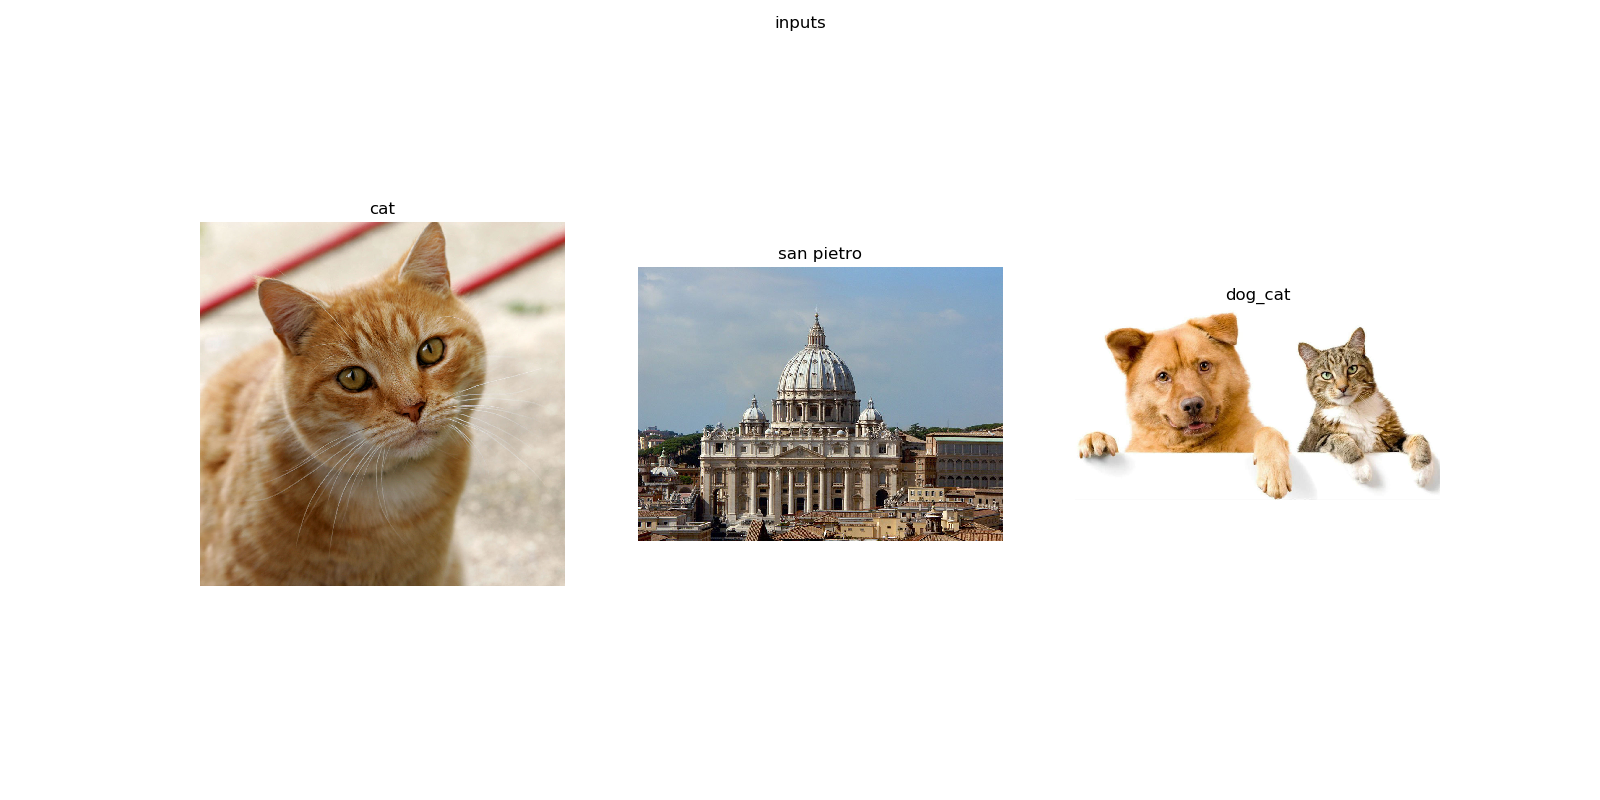

In [6]:
import glob
import matplotlib.pyplot as plt
import numpy as np

from visualisation.core.utils import device 
from PIL import Image

image_paths = glob.glob('./images/*.*')

images = list(map(lambda x: Image.open(x), image_paths))

subplot(images, title='inputs', rows_titles=['cat','san pietro','dog_cat'], nrows=1, ncols=3)


Since all of our models were trained on [imagenet](http://www.image-net.org/), a huge dataset with `1000` different classes, we need to parse and normalize them.

In Pytorch, we have to manually send the data to a device. In this case the device if the fist `gpu` if you have one, otherwise `cpu` is selected. 

Be aware that jupyter have not a garbage collected so we will need to manually free the gpu memory.

In [7]:
from torchvision.transforms import ToTensor, Resize, Compose, ToPILImage
from visualisation.core import *
from visualisation.core.utils import image_net_preprocessing

inputs  = [Compose([Resize((224,224)), ToTensor(), image_net_preprocessing])(x).unsqueeze(0) for x in images]  # add 1 dim for batch
inputs = [i.to(device) for i in inputs]

[tensor([[[[1.6153, 1.6667, 1.7009,  ..., 1.8379, 1.8550, 1.8550],
           [1.5982, 1.6667, 1.7180,  ..., 1.8722, 1.8893, 1.8893],
           [1.5982, 1.6495, 1.7009,  ..., 1.9235, 1.9235, 1.9235],
           ...,
           [1.1015, 1.1529, 1.0844,  ..., 1.6324, 1.6324, 1.6153],
           [1.1015, 1.1358, 1.1015,  ..., 1.6838, 1.6838, 1.6838],
           [1.0844, 1.0844, 1.0844,  ..., 1.7009, 1.7180, 1.7352]],
 
          [[1.6232, 1.6758, 1.7283,  ..., 1.8859, 1.8683, 1.8508],
           [1.6057, 1.6758, 1.7458,  ..., 1.9034, 1.8859, 1.8508],
           [1.6408, 1.6758, 1.7633,  ..., 1.8683, 1.8333, 1.7808],
           ...,
           [0.7129, 0.7479, 0.6954,  ..., 1.5707, 1.5882, 1.5882],
           [0.7304, 0.7654, 0.7304,  ..., 1.6408, 1.6408, 1.6232],
           [0.6779, 0.7129, 0.7129,  ..., 1.6583, 1.6758, 1.6933]],
 
          [[1.2980, 1.3502, 1.4897,  ..., 1.8731, 1.8557, 1.8557],
           [1.2457, 1.3502, 1.4897,  ..., 1.8905, 1.8731, 1.8557],
           [1.2282, 1.35

We also define an utility function to clean the gpu cache

In [9]:
def free(modules):
    for m in modules:
        del m
    torch.cuda.empty_cache()


As we said, `imagenet` is a huge dataset with `1000` classes, represented by an integer not very human interpetable. We can associate each class id to its label by loading the `imaganet2human.txt` and create a python dictionary.

In [9]:
imagenet2human = {}

with open('imaganet2human.txt') as f:
    for line in f.readlines():
        key, value = line.split(':')
        key = key.replace('{', '').replace('}', '') # I forget how regex works :) 
        value = value.replace("'", '').replace(",", '')
        imagenet2human[int(key.strip())] = str(value.strip())
        
list(imagenet2human.items())[:2]

[(0, 'tench Tinca tinca'), (1, 'goldfish Carassius auratus')]

# Weights Visualization
The first straightforward visualization is to just plot the weights of a target Layer. Obviously, the deeper we go the smaller each image becomes while the channels number increases. We are going to show each channel as a grey array image. Unfortunately, each Pytorch module can be nested and nested, so to make our code as general as possible we first need to trace each sub-module that the input traverse and then store each layer in order. We first need to `trace` our model to get a list of all the layers so we can select a target layer without following the nested structure of a model. In`PyTorch` models can be infinitely nested. In other words, we are flattering the model's layers, this is implemented in the [`module2traced`](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/blob/master/utils.py#) function.

In [12]:
model_traced = module2traced(model, inputs[0])
model_traced

[Conv2d(3, 64, kernel_size=(11, 11), stride=(4, 4), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(64, 192, kernel_size=(5, 5), stride=(1, 1), padding=(2, 2)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 Conv2d(192, 384, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(384, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 Conv2d(256, 256, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)),
 ReLU(inplace=True),
 MaxPool2d(kernel_size=3, stride=2, padding=0, dilation=1, ceil_mode=False),
 AdaptiveAvgPool2d(output_size=(6, 6)),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=9216, out_features=4096, bias=True),
 ReLU(inplace=True),
 Dropout(p=0.5, inplace=False),
 Linear(in_features=4096, out_features=4096, bias=True),
 ReLU(inplace=True),
 Linear(in_features=4096, out_features=1000, bias=True)]

Let's plot the first layer's weight. We also print the shape of the weight to give a correct idea to the reader of the dimensional reduction. 

In [11]:
vis = Weights(model, device)

torch.Size([1, 55, 55])


<IPython.core.display.Javascript object>


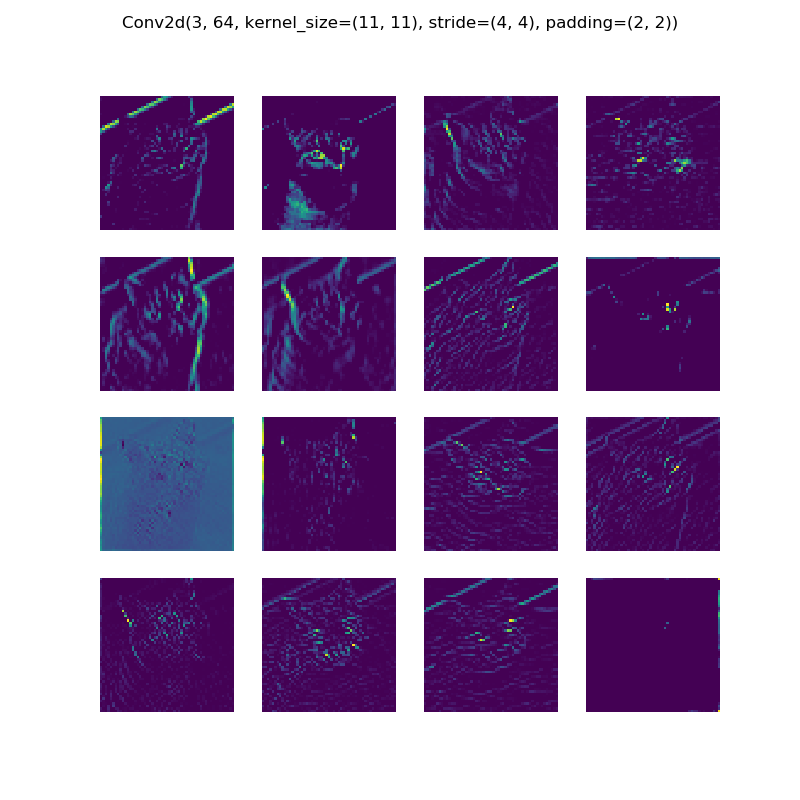

In [14]:
first_layer = model_traced[0]

plt.rcParams["figure.figsize"]= 8,8
    
run_vis_plot(vis, inputs[0], first_layer, ncols=4, nrows=4)

Let's stop for a minute to explain what those images represent. We traced the input through the computational graph in order to find out all the layers of our models, in this case, `alexnet`. Then we instantiate the `Weights` class implemented in `visualisation.core` and we call it by passing the current input, the **cat** image and a **target layer**. As outputs, we get all the current layer's weights as grey images. Then, we plot 16 of them. We can notice that they, in some way, makes sense; for example, some pixels are brighter in the edges of the images.

Let's plot the first `MaxPool` layer to better see this effect, dimensional reduction and higher brightness pixels in some interesting areas. 

If you are wondering what the maxpolling operations is doing, check this awesome [repo](https://github.com/vdumoulin/conv_arithmetic)

torch.Size([1, 27, 27])


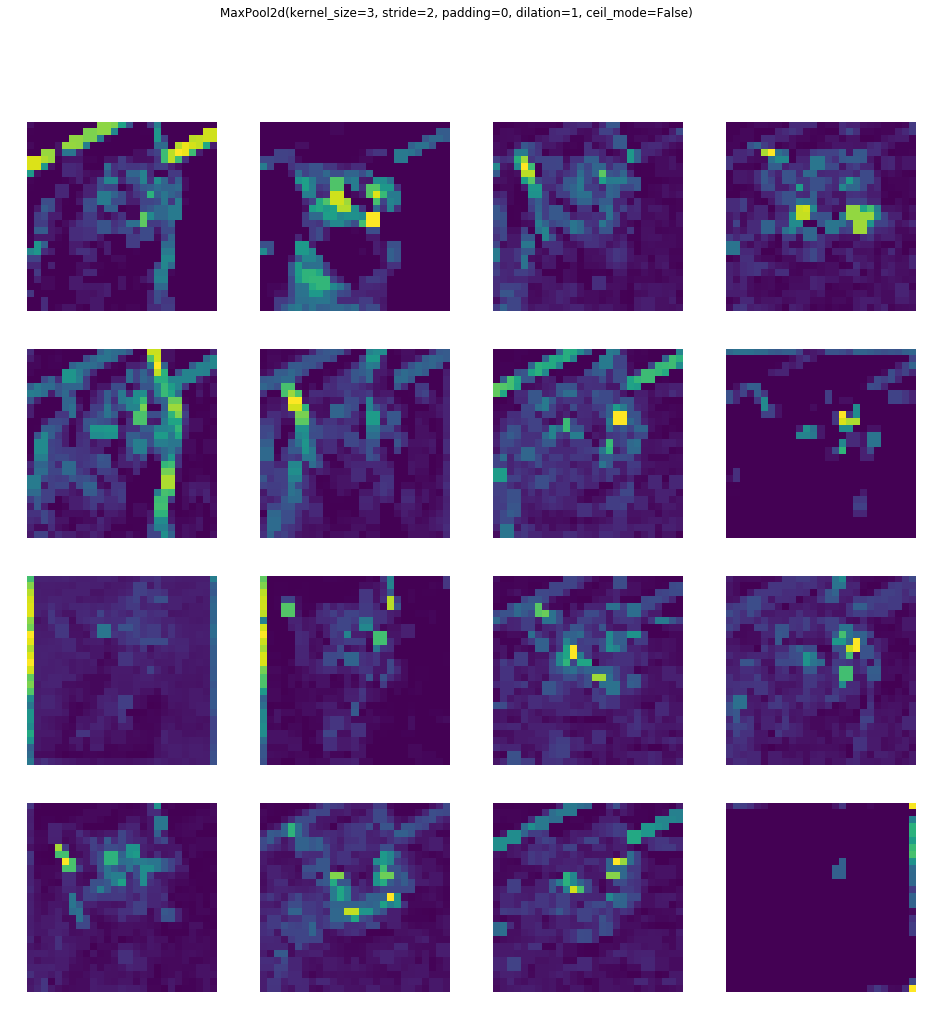

In [13]:
first_maxpool_layer = model_traced[2]

run_vis_plot(vis, inputs[0], first_maxpool_layer, ncols=4, nrows=4)

Let's try with an other input, the San Pietro Basilica

torch.Size([1, 27, 27])


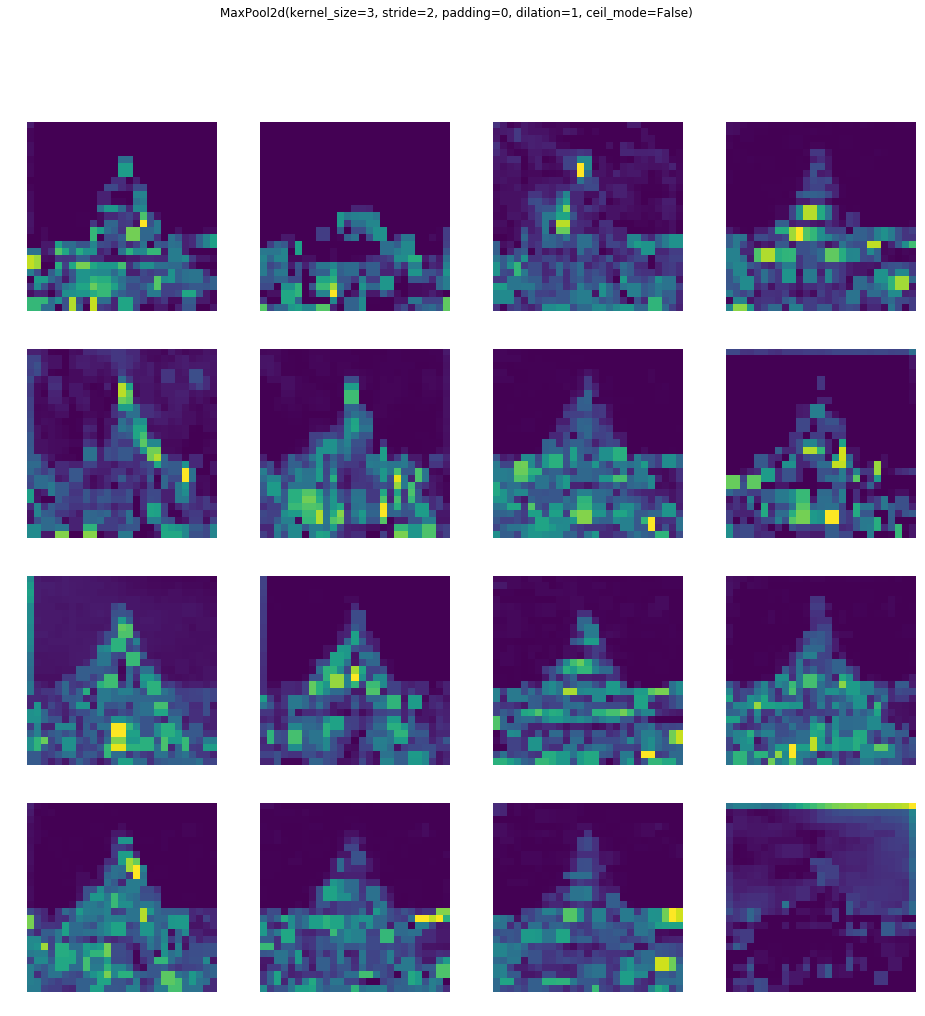

In [14]:
run_vis_plot(vis, inputs[1], first_maxpool_layer, ncols=4, nrows=4)

By looking at them, these images make somehow sense; they highlight the basilica layout but it is hard to understand what the model is actually doing. We got the idea that is computing something correctly but we could ask some questions, for example: is it looking at the cupola? Which are the most important features of the Basilica?

Moreover, the deeper we go the harder it becomes to even recognize the input. 

torch.Size([1, 13, 13])


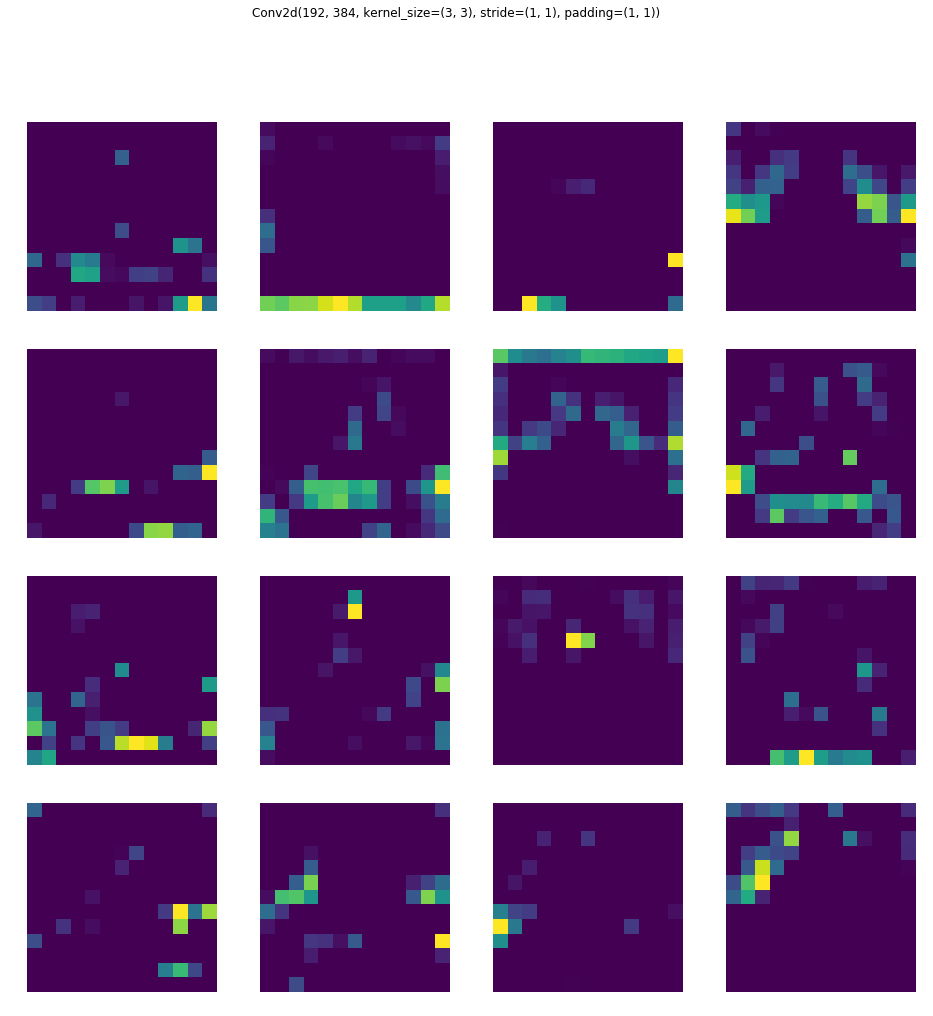

In [15]:
deeper_layer = model_traced[6]
run_vis_plot(vis, inputs[1], deeper_layer, ncols=4, nrows=4)

In this case, we have no idea of what is going on. It can be argued that weights visualization does not carry any useful information about the model, even if this is almost true, there is one nice reason of plotting the weights especially at the first layer.

When a model is poorly trained or not trained at all, the first weights have lots of noise, since they are just randomly initialized, and they are a lot more similar to the inputs images than the trained ones. This feature can be useful to understand on the fly is a model is trained or not. However, except for this, weights visualization is not the way to go to understand what your black box is thinking. Below we plot the first layer's weight first for the untraind version of `alexnet` and the for the trained one. 

torch.Size([1, 55, 55])
torch.Size([1, 55, 55])


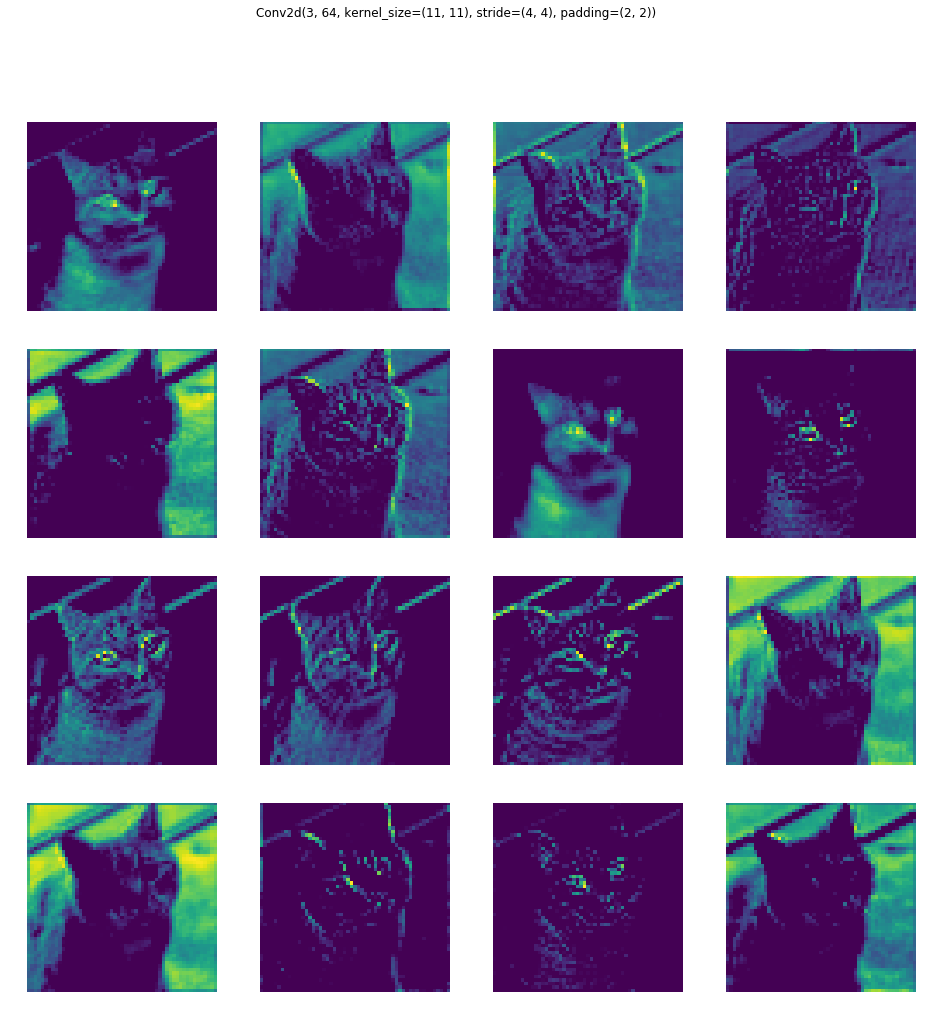

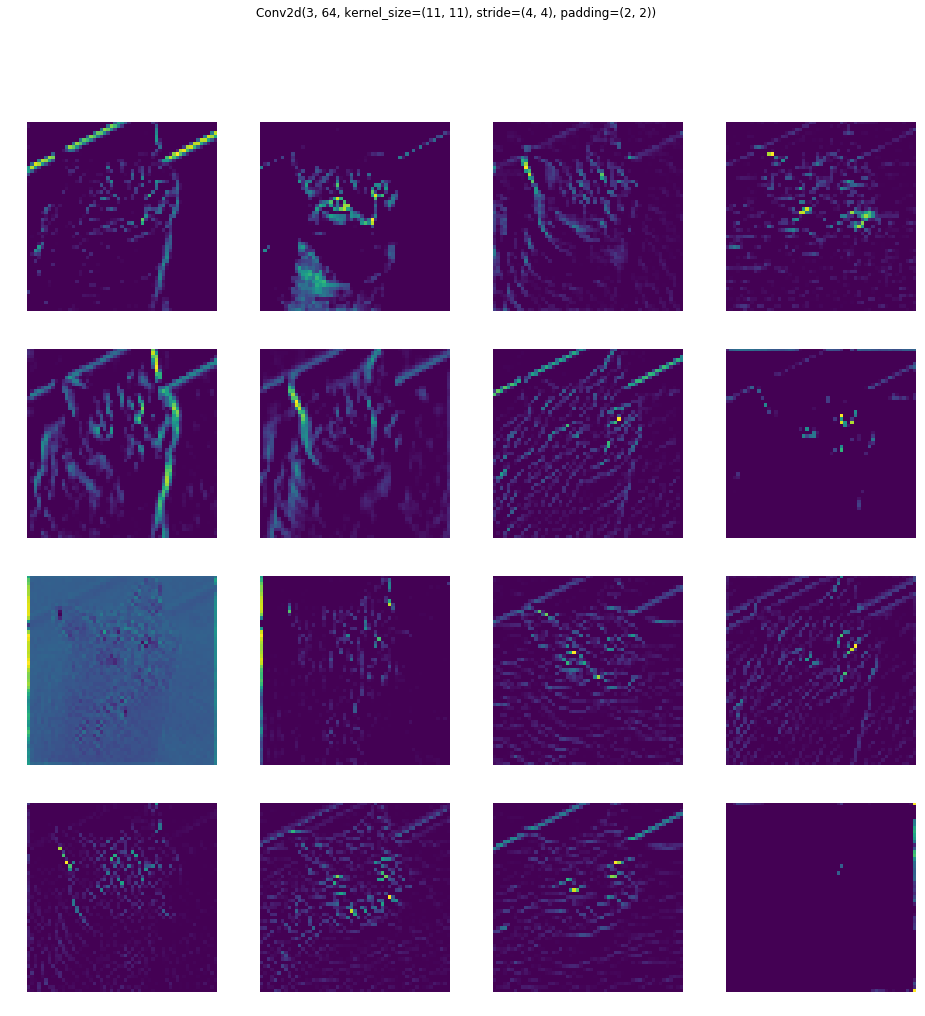

In [16]:
alexnet_not_pretrained = alexnet(pretrained=False).to(device)

run_vis_plot(Weights(alexnet_not_pretrained, device), 
             inputs[0], 
             module2traced(alexnet_not_pretrained, inputs[0])[0],
             ncols=4, nrows=4)

alexnet_pretrained = alexnet(pretrained=True).to(device)

run_vis_plot(Weights(alexnet_pretrained, device), 
             inputs[0], 
             module2traced(alexnet_pretrained, inputs[0])[0],
             ncols=4, nrows=4)

del alexnet_not_pretrained

You can notice that in the first image is simpler to see the input image. Hoewer, this is not a general rule, but in some cases it can help.

## Similarities with other models

We have seen `alexnet`'s weights, but are they similar across models? Below we plot the first 4 channel of each first layer's weight for `alexnet`, `vgg` and `resnet` 

Downloading: "https://download.pytorch.org/models/resnet34-333f7ec4.pth" to /home/tomasz/.cache/torch/checkpoints/resnet34-333f7ec4.pth
100%|██████████| 83.3M/83.3M [00:04<00:00, 20.0MB/s]


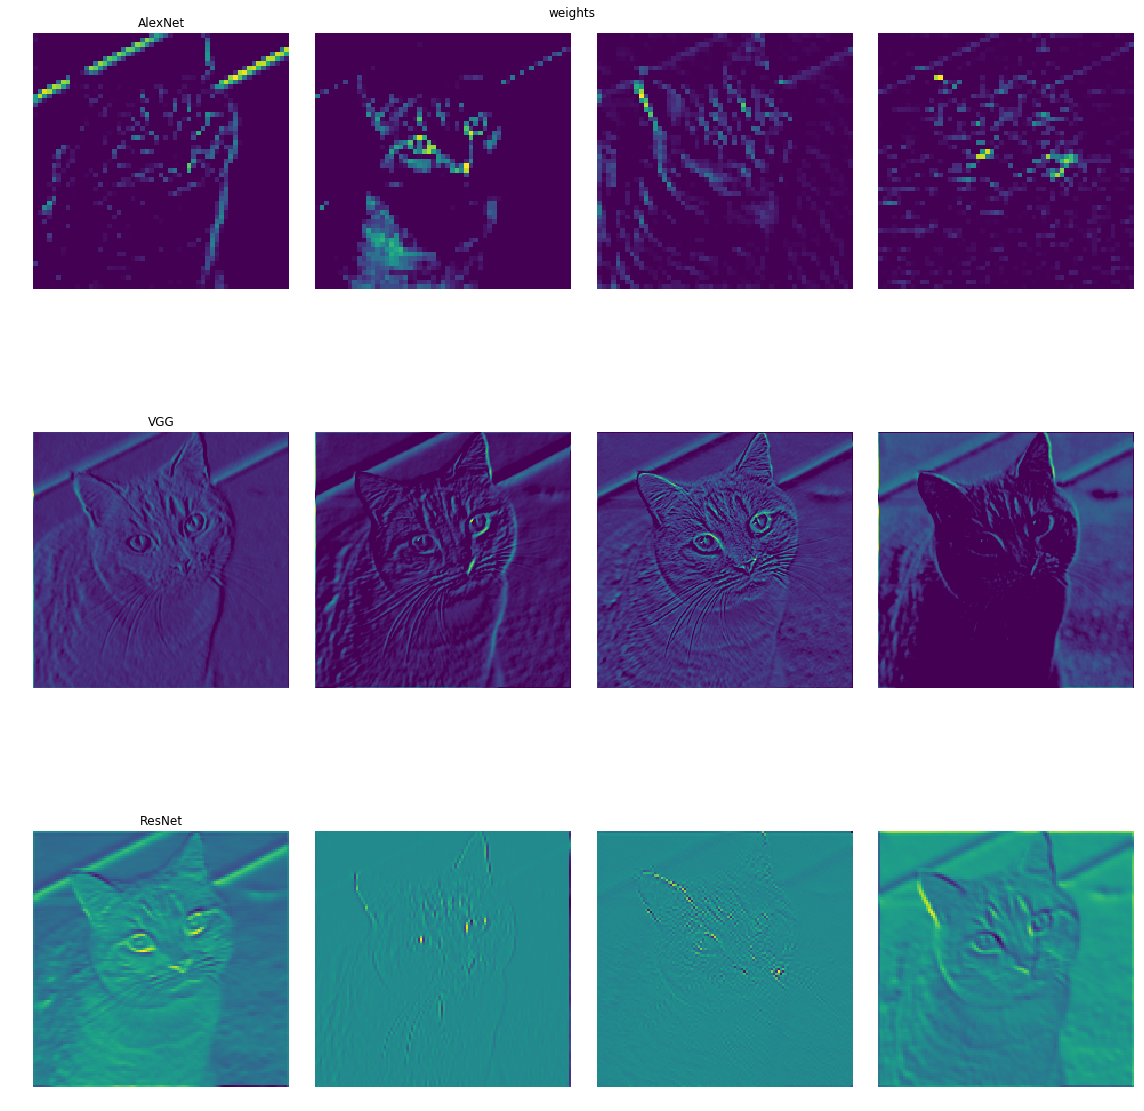

In [17]:
modules_instances = [alexnet, vgg16, resnet34]

modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, Weights , 'weights', device, ncols=4)

free(modules)

The `resnet` and `vgg` weights looks more similar to the input images than `alexnet`. But, again, what does it mean? Remember that at least resnet is initialized in a different way than the other two models.

# Saliency Visualisation
One idea proposed by [*Deep Inside Convolutional Networks: Visualising Image Classification Models and Saliency Maps*](https://arxiv.org/abs/1312.6034) is to back-prop the output of the network with respect to a target class until the input and plot the computed gradient. This will highligh the part of the image responsible for that class. Let's start with alexnet.

Let's first print the prediction of the network (this could change if you re-run the cell)

In [17]:
model.eval()
pred = model(inputs[0])
_, id = torch.max(pred, 1)

print('predicted class {}'.format(imagenet2human[id.item()]))

predicted class tiger cat


Each visualisation is implemented in its own class. You can find the code [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/blob/master/visualisation/core/SaliencyMap.py). It will backproprop the output with respect to the one hot encoding representation of the number corresponding to `class tiger cat`

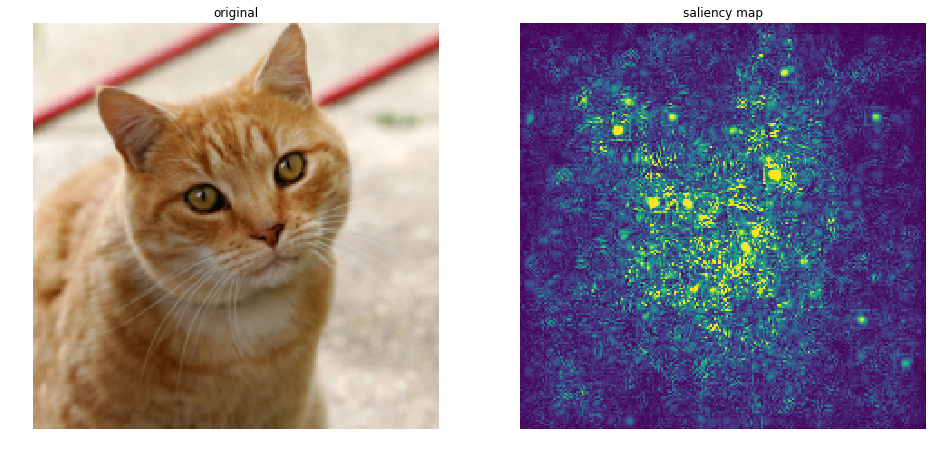

In [18]:
from visualisation.core.utils import image_net_postprocessing
model.eval()
model = model.to(device)
vis = SaliencyMap(model, device)

out, info = vis(inputs[0], 
          first_layer)

subplot([image_net_postprocessing(inputs[0].squeeze().cpu()), out], 
        rows_titles=['original', 'saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)


We can see that `alexnet` gets exited on the cat. We can even do better! We can set to `0` each **negative** relu gradient when backprop. This is techinique is called `guided`.

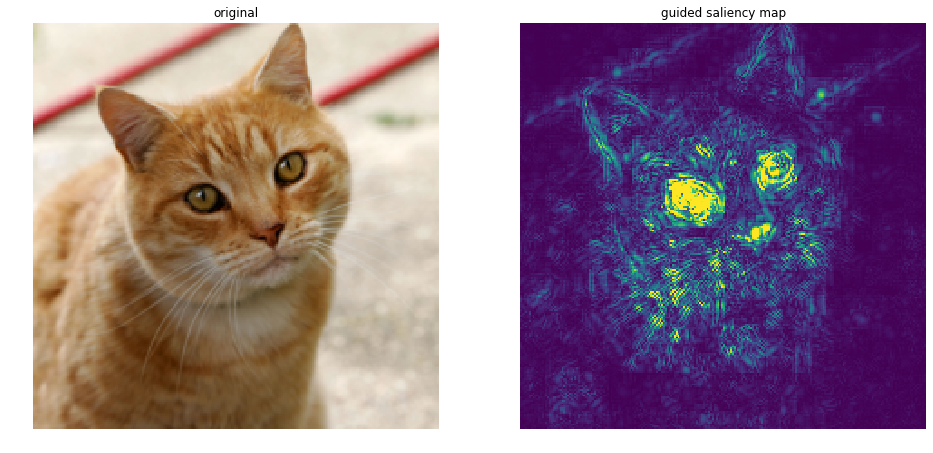

In [19]:
out, info = vis(inputs[0], 
          first_layer,
          guide=True)

subplot([image_net_postprocessing(inputs[0].squeeze().cpu()), out], 
        rows_titles=['original', 'guided saliency map'],
        parse=tensor2img, 
        nrows=1, ncols=2)

Now we can clearly see that the network is looking at the eyes and the nose of the cat. We can try to compare different models

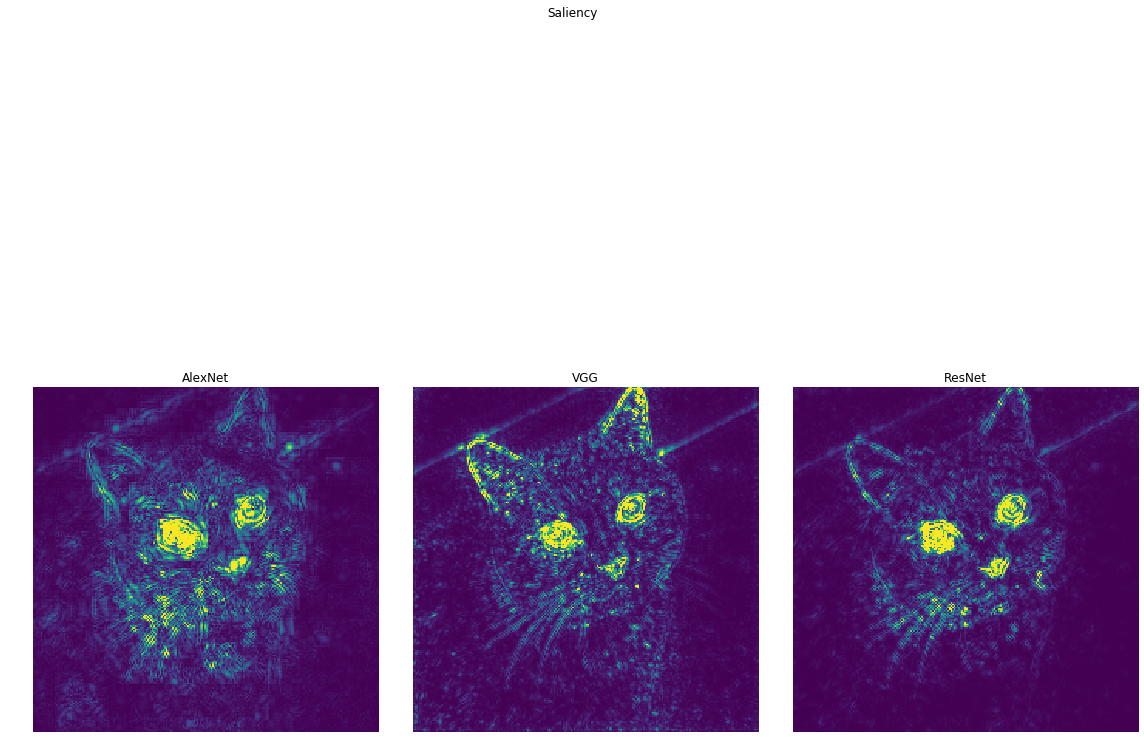

In [20]:
modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], 0, SaliencyMap , 'Saliency', device, nrows=1, ncols=3, target_class=231, guide=True)

free(modules)

`Alextnet` seems more interested to the eyes, while `VGG` looks at the ears and resnet is similar to `alexnet`. Now we can clearly understand which part of the inputs help the network gives that prediction.

While guiding yields a better human interpretable image, the vanilla implementation can be used for localizing an object of interest. In other words, we can find object of interest for free by cropping out of the input image the region corresponding to the gradient. Let's plot each input image for each model.

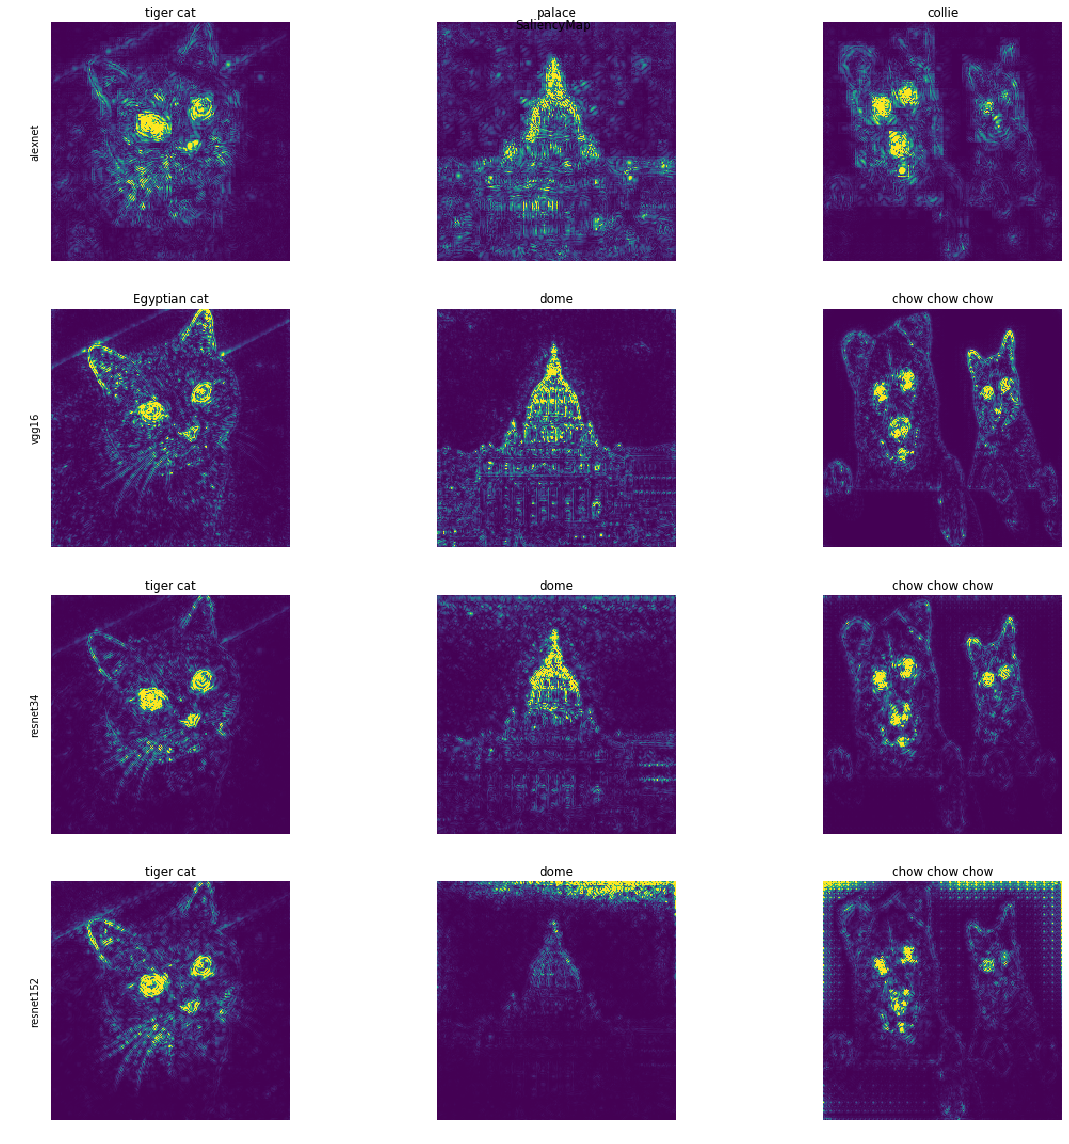

In [21]:
modules_instances = [alexnet, vgg16, resnet34, resnet152]

modules = (m(pretrained=True) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once


run_vis_plot_across_models(modules, inputs[0], None, SaliencyMap , 'SaliencyMap',  device,
                           nrows=4, 
                           ncols=3, 
                           inputs=inputs,
                           idx2label=imagenet2human,
                           annotations=['alexnet', 'vgg16', 'resnet34', 'resnet152'],
                           guide=True)

free(modules)

The Basilica is very interesting, all four networks correctly classify it as a `dome` but only `resnet152` is more interested in the sky than on the cupola. In the last column, we have an image with two classes, `dog` and `cat`. All the networks highlighted booths, like the eyes of the dog and the ears of the cat in `vgg16`. What if we would like to discover only the region of the inputs that are related to a specific class? With this technique is impossible.

# Class Activation Mapping
*Class Activation Mapping* is a techniques presented in [Learning Deep Features for Discriminative Localization](https://arxiv.org/pdf/1512.04150.pdf). The idea is to use the last convolutional layer output and the neurons in the linear layer of the model responsable for a target class, the map is generated by taking the dot product of those. However, to make this work the model has to have some constrains. First of all, the output from the convolution must first go trought an **global average polling** and it requires feature maps to directly precede softmax layers. To make it works with other architecture, such as `alexnet` and `vgg` we have to change some layers in the model and retrain it. This is a major drawback that will be solved with the next section. For now, we can use it for free with resnet! Since its architecture is perfect.

![alt](./resources/images/class_activation_mapping1.png)

The implementation can be found [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/blob/master/visualisation/core/ClassActivationMapping.py). We can pass to the visualisation a `target_class` parameter to get the relative weights from the fc layer.

Notice that by changing the target class, we can see different part of the image highlighted. The first image uses the prediction class, while the second an other type of `cat` and the last one  `bookcase`, just to see what the model will do with a wrong class. 

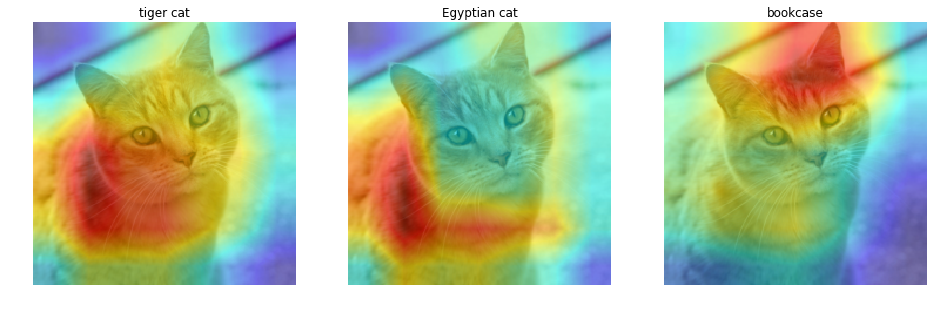

In [22]:
from visualisation.core.utils import imshow
# we are using resnet 34 since the model has only one fc layer before the softmax and it is preceded by av avg pool
# as required from the paper
module = resnet34(True).to(device)
module.eval()

vis = ClassActivationMapping(module, device)

classes = [None, 285, 453]

def vis_outs2images_classes(outs):
    images = [x[0] for x in outs]
    classes = [imagenet2human[int(x[1]['prediction'])] for x in outs]
    
    return images, classes

outs = [vis(inputs[0], None, 
          postprocessing=image_net_postprocessing, 
          target_class=c,
          guide=True) for c in classes]

images, classes = vis_outs2images_classes(outs)

subplot(images, 
        rows_titles=classes,
        nrows=1, 
        ncols=3, 
        parse=tensor2img)

It makes sense, the only thing is that in the last row we still have some part of the cat highlighted for `bookcase`

Let's plot the CAM on the `cat` images for different `resnet` architecture. For resnet > 34 the `Bottleneck` module is used

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


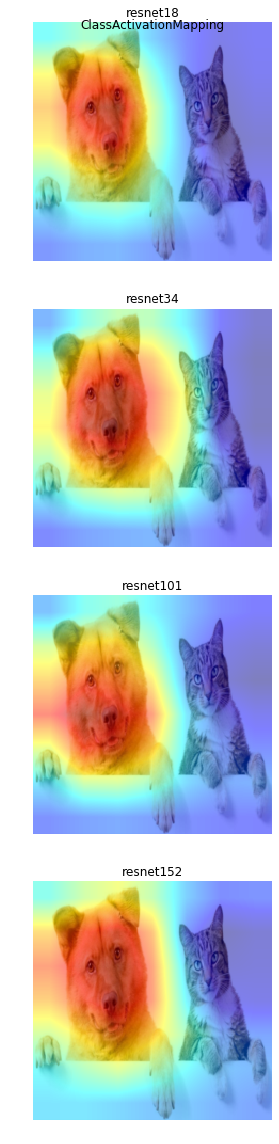

In [23]:
modules_instances = [resnet18, resnet34, resnet101, resnet152]

cat = inputs[2]

modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, cat, None, 
                           ClassActivationMapping , 
                           'ClassActivationMapping',
                           device,
                           nrows=len(modules_instances),
                           ncols=1,
                           postprocessing=image_net_postprocessing, 
                           rows_name = ['resnet18', 'resnet34', 'resnet101', 'resnet152'],
                           target_class=None)

free(modules)

They are all very similar as expected. One big drawback of this technique is that force you to use a network with a specific architecture, global polling before the decoder part. The next technique generalize this approach by taking advantage of the gradient at one specific layer. Remember that with the *class activation* we are using the weights of the feature map as a scaling factor for the channels of the last layer. The features map must be before a softmax layer and right after the average pooling. The next technique propose a more general approach.

# Grad Cam

**Grad Cam** was introduced by [Grad-CAM: Visual Explanations from Deep Networks via Gradient-based Localization](https://arxiv.org/abs/1610.02391). The idea is actually simple, we backprop the output with respect to a target class while storing the gradient and the output at a given layer, in our case the last convolution. Then we perform a global average of the saved gradient keeping the channel dimension in order to get a 1-d tensor, this will represent the importance of each channel in the target convolutional layer. We then multiply each element of the convolutional layer outputs by the averaged gradients to create the grad cam. This whole procedure is fast and it is architecture independent. Interesting, the authors show that is a generalization of the previous technique.


![alt](./resources/images/grad_cam1.png)

The code is [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/blob/master/visualisation/core/GradCam.py)

We can use it to higlight what different models are looking at.

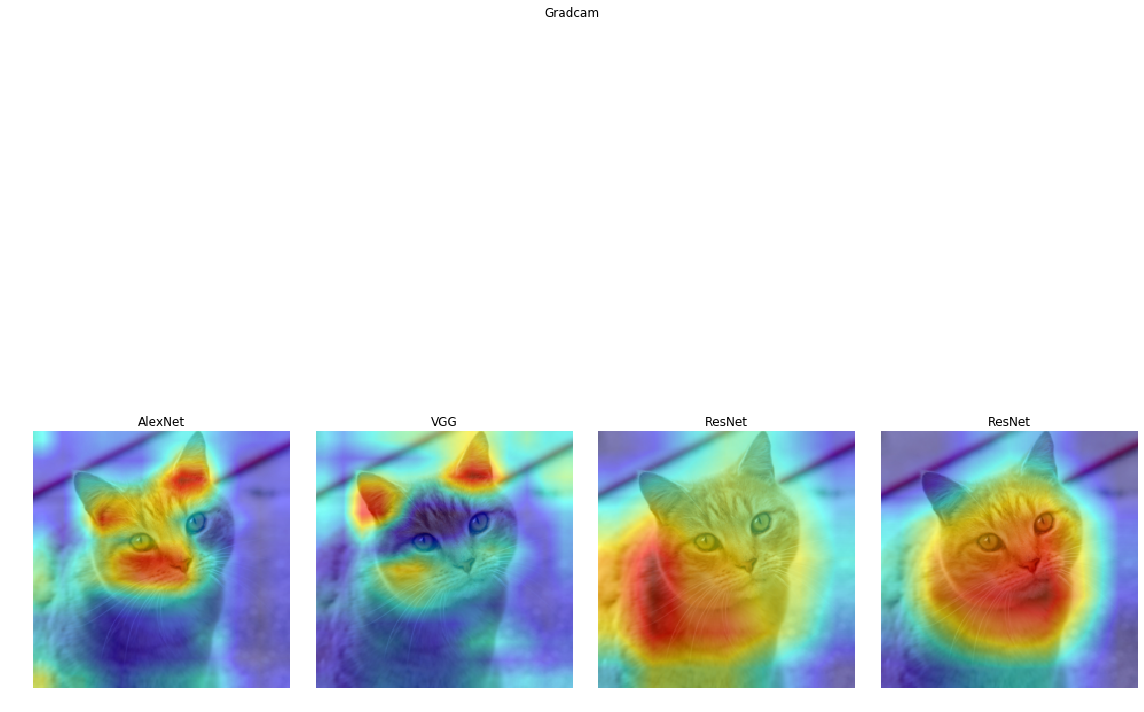

In [24]:
modules_instances = [alexnet, vgg16, resnet34, resnet152]

modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], None, GradCam , 'Gradcam', device,
                           nrows=1, 
                           ncols=4, 
                           target_class=None, 
                           postprocessing=image_net_postprocessing)
free(modules)

It is really interesting to see how `alexnet` looks at the nose, while `vgg` at the ears and `resnet` at the whole cat. It is interesting to see that the two `resnet` version looks at different part of the cat.

Below we plot the same input for `resnet34` but we change the target class in each column to show the reader how the grad cam change accordingly.

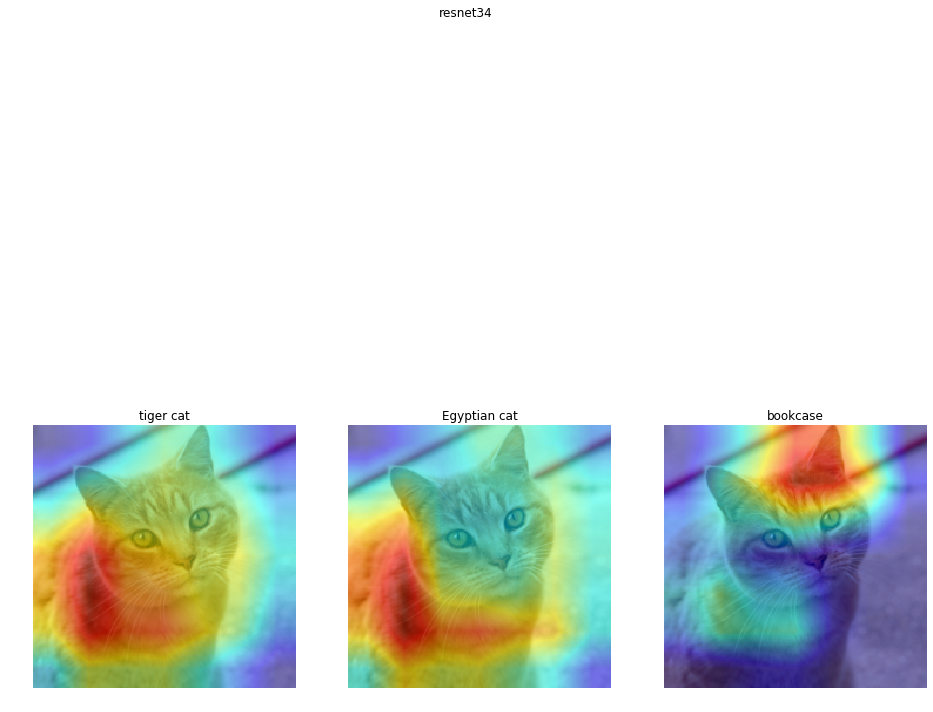

In [25]:
from visualisation.core.utils import imshow

module = module.to(device)

vis = GradCam(module, device)

classes = [None, 285, 453]
outs = [vis(inputs[0], None, 
          postprocessing=image_net_postprocessing, 
          target_class=c) for c in classes]

images, classes = vis_outs2images_classes(outs)

subplot(images,
        title='resnet34',
        rows_titles=classes,
        nrows=1, 
        ncols=len(outs), 
        parse=tensor2img)

Notice how similar to the `CAM` output they are. To better compore our three models, below we plot the grad cam for each input with respect to each model

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


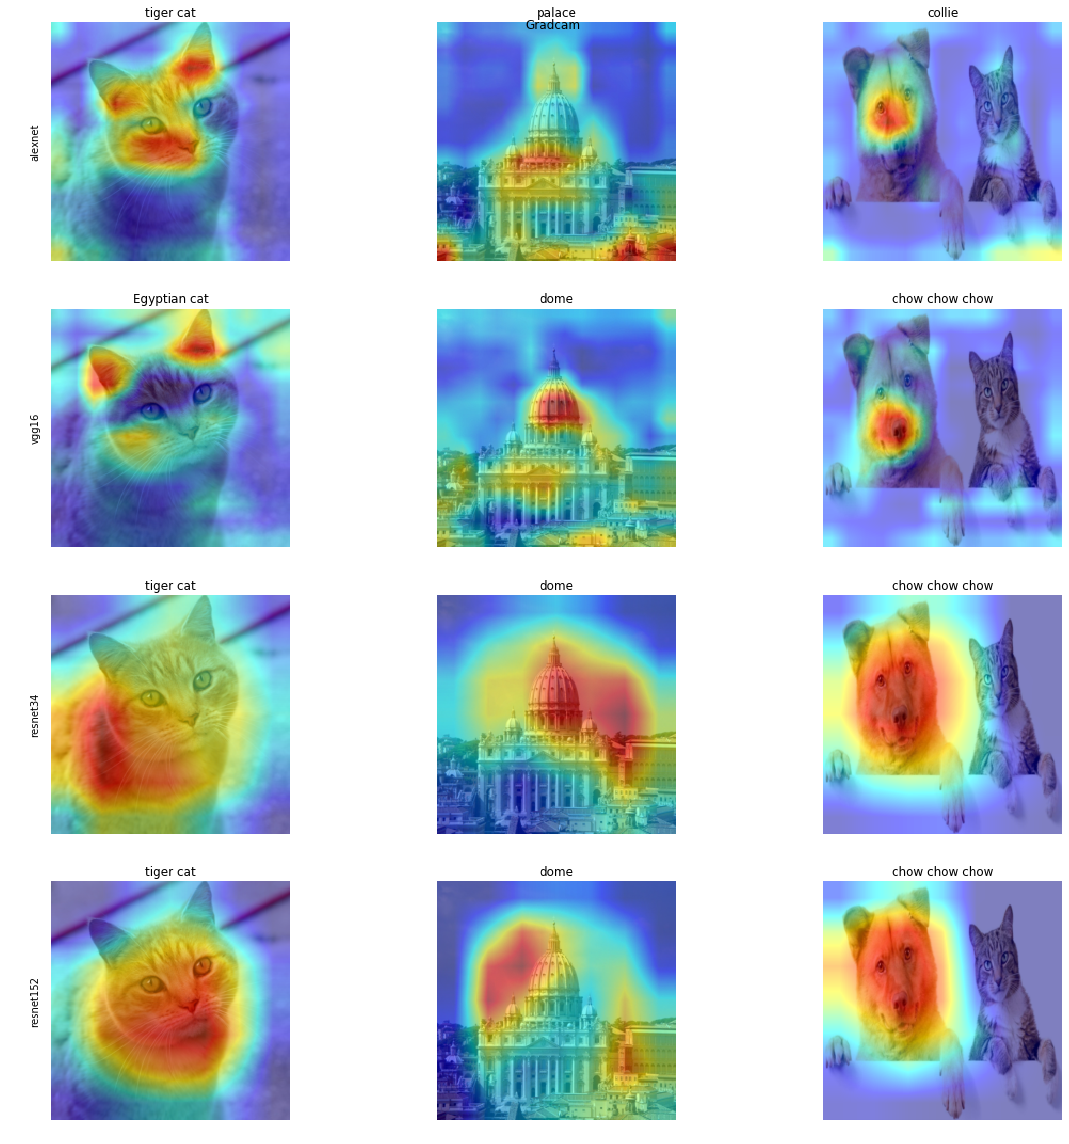

In [26]:
modules = (m(pretrained=True).to(device) for m in modules_instances) # make a generator, we don't want to store in memory all of them at once

run_vis_plot_across_models(modules, inputs[0], None, GradCam , 'Gradcam', device,
                           nrows=4, 
                           ncols=3, 
                           target_class=None, 
                           inputs=inputs,
                           idx2label=imagenet2human,
                           annotations=['alexnet', 'vgg16', 'resnet34', 'resnet152'],
                           postprocessing=image_net_postprocessing)

free(modules)

The reader can immediately notice the difference across the models.

### Interesting region 
We talk before about interesting region localizations. Grad-cam can be also used to extract the class object out of the image. Easily, once the have the grad-cam image we can used it as mask to crop out form the input image what we want. The reader can play with the `TR` parameter to see different effects.

In [27]:
TR =  0.3

In [28]:
alexnet_pretrained.eval() 

vis = GradCam(alexnet_pretrained, device)

_ = vis(inputs[0], None, 
          postprocessing=image_net_postprocessing)


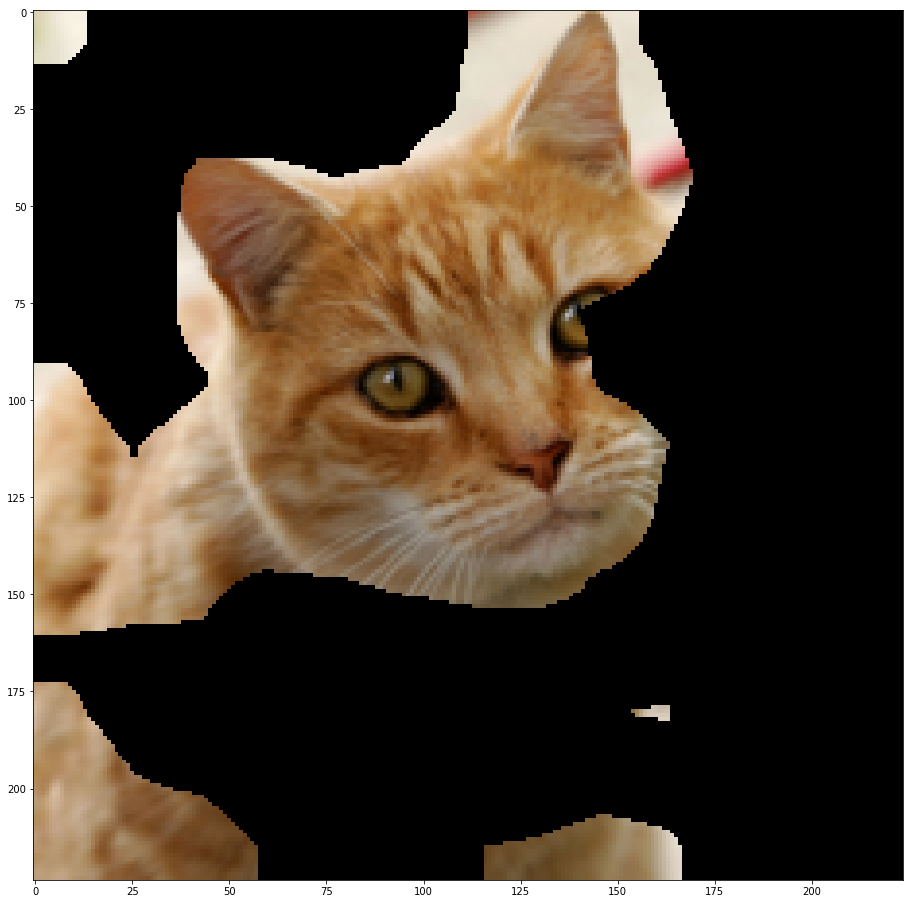

In [29]:
import cv2

def gradcam2crop(cam, original_img):
    b, c, w, h = inputs[0].shape
    cam = cam.numpy()
    cam -= np.min(cam)
    cam /= np.max(cam) 
    
    cam = cv2.resize(cam, (w,h))
    mask = cam > TR

    original_img = tensor2img(image_net_postprocessing(original_img[0].squeeze()))

    crop = original_img.copy()
    crop[mask == 0] = 0
    
    return crop

crop = gradcam2crop(vis.cam.cpu(), inputs[0].cpu())

fig = plt.figure()
plt.imshow(crop)

*et voilà*! We can also change again class, and crop the interest region for that class.

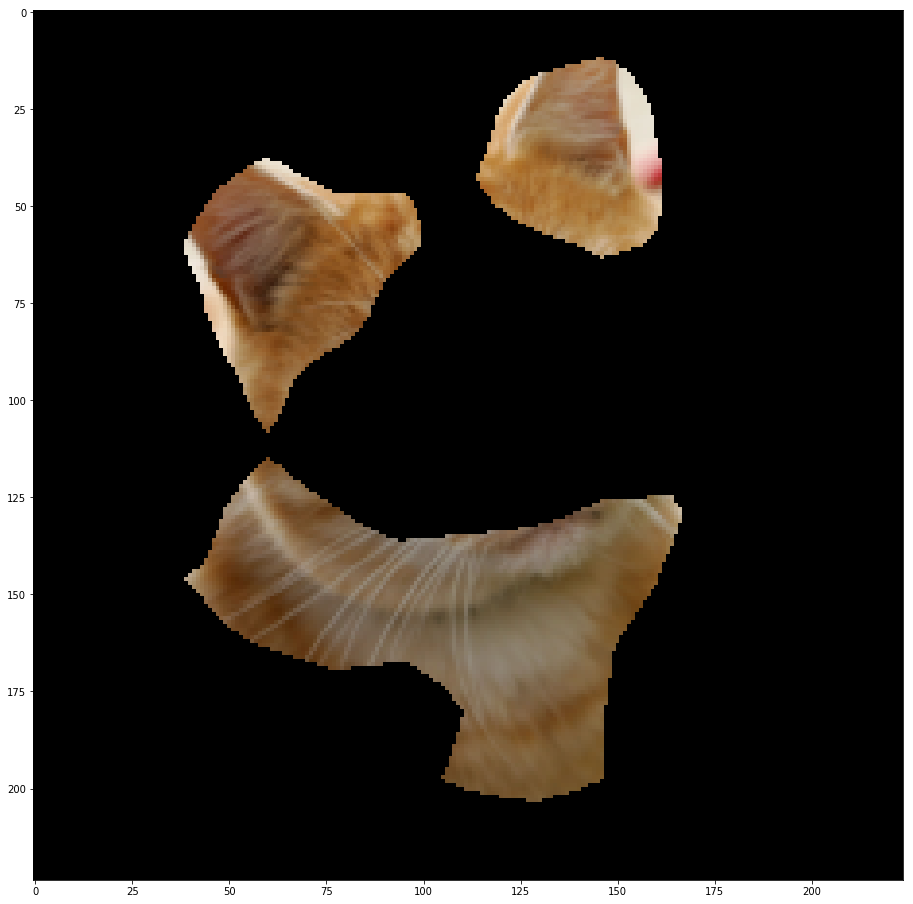

In [30]:
_ = vis(inputs[0], None, 
        target_class=231,
          postprocessing=image_net_postprocessing)

crop = gradcam2crop(vis.cam.cpu(), inputs[0].cpu())

fig = plt.figure()
plt.imshow(crop)

## Different models

We have seen all these techniques used with classic classicification models trained on `imagenet`. What about use them on a different domain? I have ported this paper to Pytorch and retrain it. The model learn from the frontal camera's image of a robot to predict the local distance sensors in order to avoid obstacles. Let's see what if, by using those techniques, we can understand better what is going on inside the model.

### Learning Long-range Perception using Self-Supervision from Short-Range Sensors and Odometry

The idea is to predict the future outputs of a short-range sensor (such as a proximity sensor) given the current outputs of a long-range sensor (such as a camera). They trained a very simple CNN from the robot's camera images to predict the proximity sensor values. If you are interested in their work, you can read the full paper [here](https://arxiv.org/abs/1809.07207)

![alt](https://raw.githubusercontent.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/master/resources/images/long_range_perception.png)

I have made a PyTorch implementation and retrain the model from scratch. Be awere that I did not fine-tune or try different sets of hyper-parameters so probably my model is not performing as well as the author's one.

Let's import it

In [31]:
from os import path

LONG_RANGE_PERCEPTION_PATH = path.abspath('./models/long_range_perception/model.pt')

In [32]:
from models.long_range_perception.model import SimpleCNN
from models.long_range_perception.utils import get_dl, H5_PATH, imshow, post_processing, pre_processing, MODEL_PATH

free([module])

module = torch.load(LONG_RANGE_PERCEPTION_PATH, map_location=lambda storage, loc: storage)

module = module.to(device)
module

/home/francesco/Documents/A-journey-into-Convolutional-Neural-Network-visualization-/model.pt


SimpleCNN(
  (encoder): Sequential(
    (0): Conv2d(3, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(10, 8, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): Dropout(p=0.2)
    (1): Linear(in_features=640, out_features=256, bias=True)
    (2): ReLU()
    (3): Linear(in_features=256, out_features=325, bias=True)
    (4): Sigmoid()
  )
)

We know need some inputs to test the model, they are taken directly from the **test set**

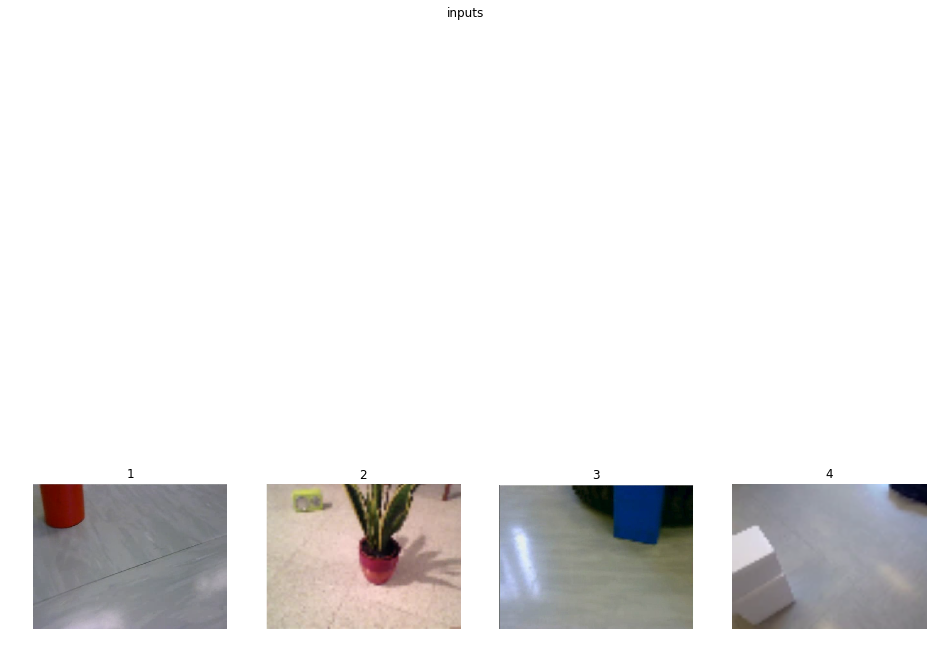

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


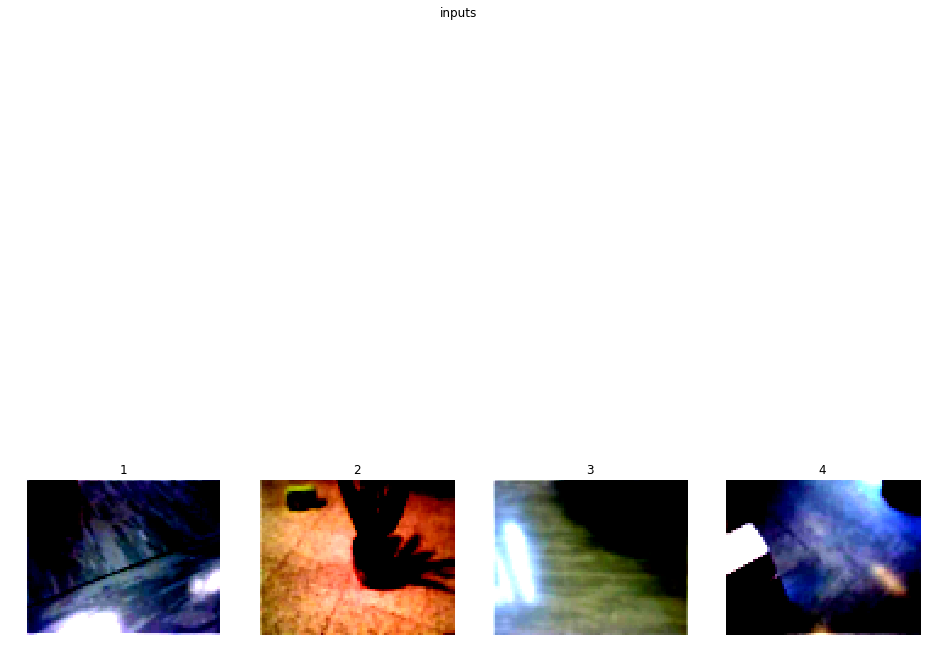

In [33]:
import os 

def make_and_show_inputs(path, transform):
    image_paths = glob.glob(path)
    image_paths = filter(lambda x: os.path.isfile(x), image_paths)

    images = list(map(lambda x: Image.open(x).convert('RGB'), image_paths))

    subplot(images, title='inputs', rows_titles=['1','2','3','4'], nrows=1, ncols=4)

    plt.show()
    
    inputs  = [pre_processing(x).unsqueeze(0).to(device) for x in images]  # add 1 dim for batch

    subplot(inputs, parse=tensor2img, title='inputs', rows_titles=['1','2','3','4'], nrows=1, ncols=4)

    return images, inputs
    
images, inputs = make_and_show_inputs('images/long_range_perception/*', pre_processing)

Then author normalize each image, this is done by callind `pre_processing`. For some reason the inpupts images are different on mac and ubuntu, they should not be like these if you run the notebook on mac the result is different. This is probably due to the warning message.

We are going to use the `SaliencyMap` and the `GradCam` since those are the best

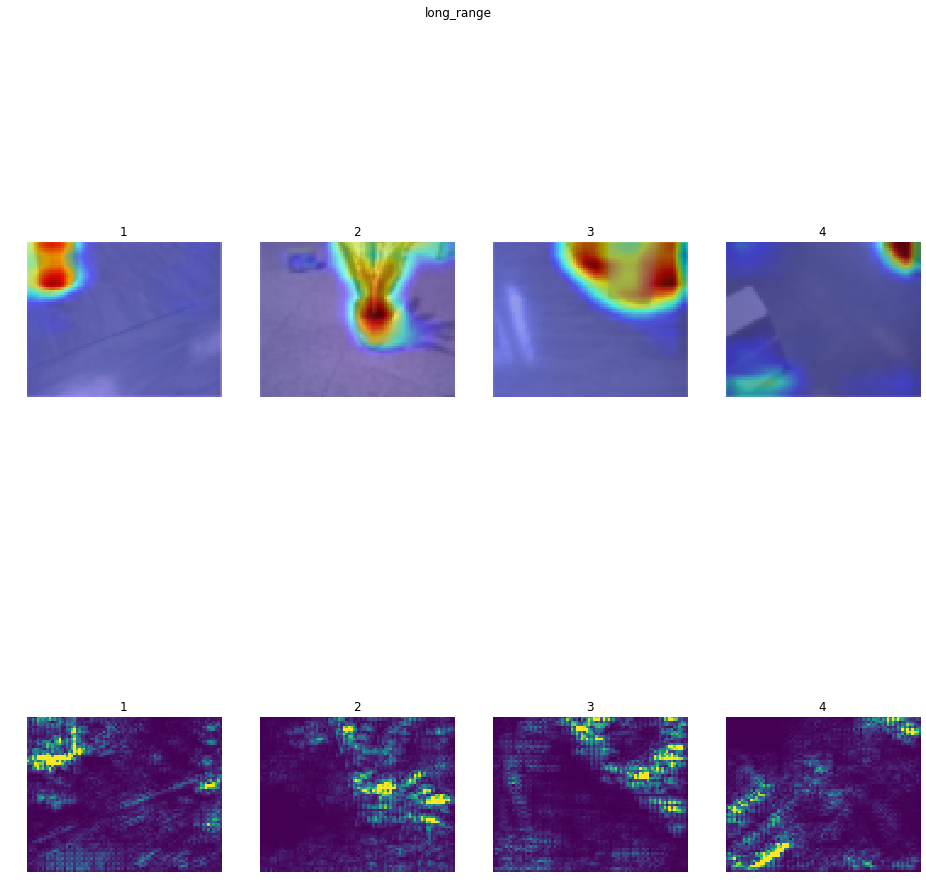

In [34]:
from torch.autograd import Variable

module.eval()

def run_long_range_vis():
    grad = GradCam(module, device)

    all_true = torch.ones(1,65*5).float().to(device)

    outs_grad = [grad(input, None, target_class=all_true, 
                      postprocessing=post_processing, 
                      regression=True)[0] for input in inputs]

    sal = SaliencyMap(module, device)

    outs_saliency = [sal(input, None, guide=True, target_class=all_true,
                        regression=True)[0] for input in inputs]

    subplot([*outs_grad, *outs_saliency],
            title='long_range',
            cols_titles=['1','2','3','4'],
            nrows=2, 
            ncols=4, 
            parse=tensor2img)
    
run_long_range_vis()

We can clearly see that the model looks at the objects. In the `GradCam` row, on the second picture, the plan is basically segmented by the heatmap. There is one problem, if you look at the third picture, the white box in front of the camera is not clearly highlighted. This is probably due to the white color of the floor that is very similar to the box's color. Let's investigate this problem. 

In the second row, the `SaliencyMaps` highlights all the objects, including the white box. The reader can notice that the reflection in the first picture on the left seems to excite the network in that region. We should also investigate this case but due to time limitations, we will leave it as an exercise for the curious reader.

For completeness, let's also print the predicted sensor output. The model tries to predict five frontal distance sensors give the image camera.

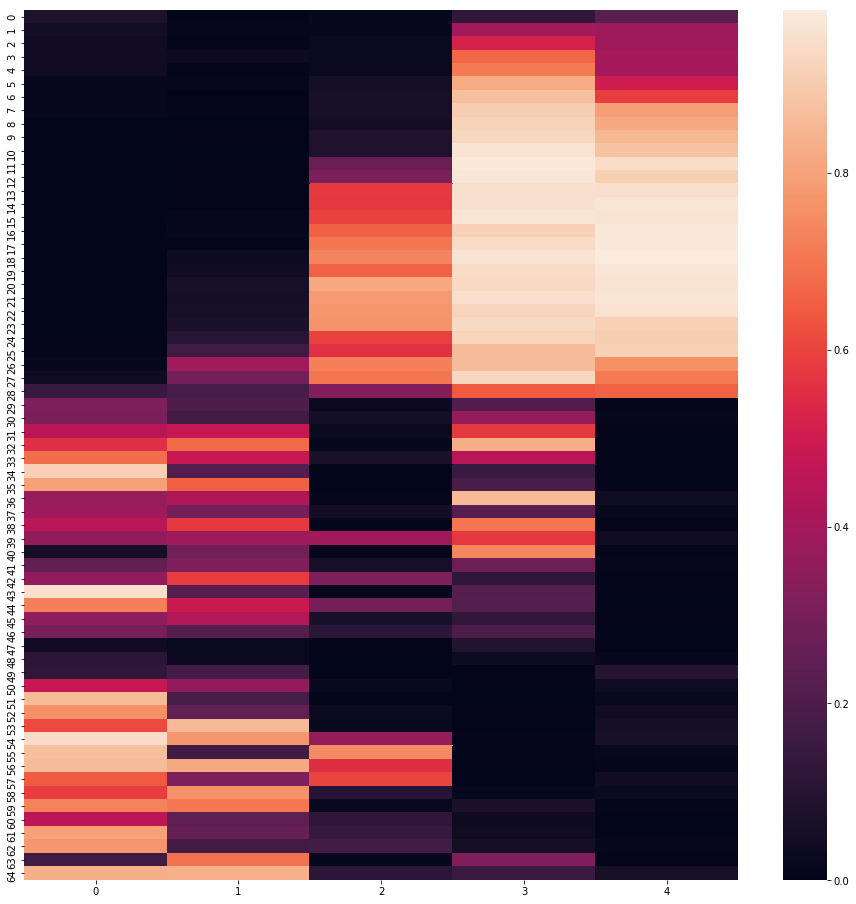

In [35]:
import seaborn as sns 

module.eval()
preds = module(torch.stack(inputs).squeeze(1))

fig = plt.figure()


sns.heatmap(preds[2].view(-1, 5).detach().cpu().numpy())

If you compare with the authors pictures, my prediction are worse. This is due to the fact that to speed up everything I did not used all the training set and I did not perform any hyper paramater optimisation. All the code con be found [here](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/tree/master/models/long_range_perception). Let's now investigate the first problem, object with a similar color to the ground.

#### Similar colors
To test if the model has a problem with obstacles with a the same color of the ground, we created in blender four different scenarios with an obstacle. They are showed in the picture below.

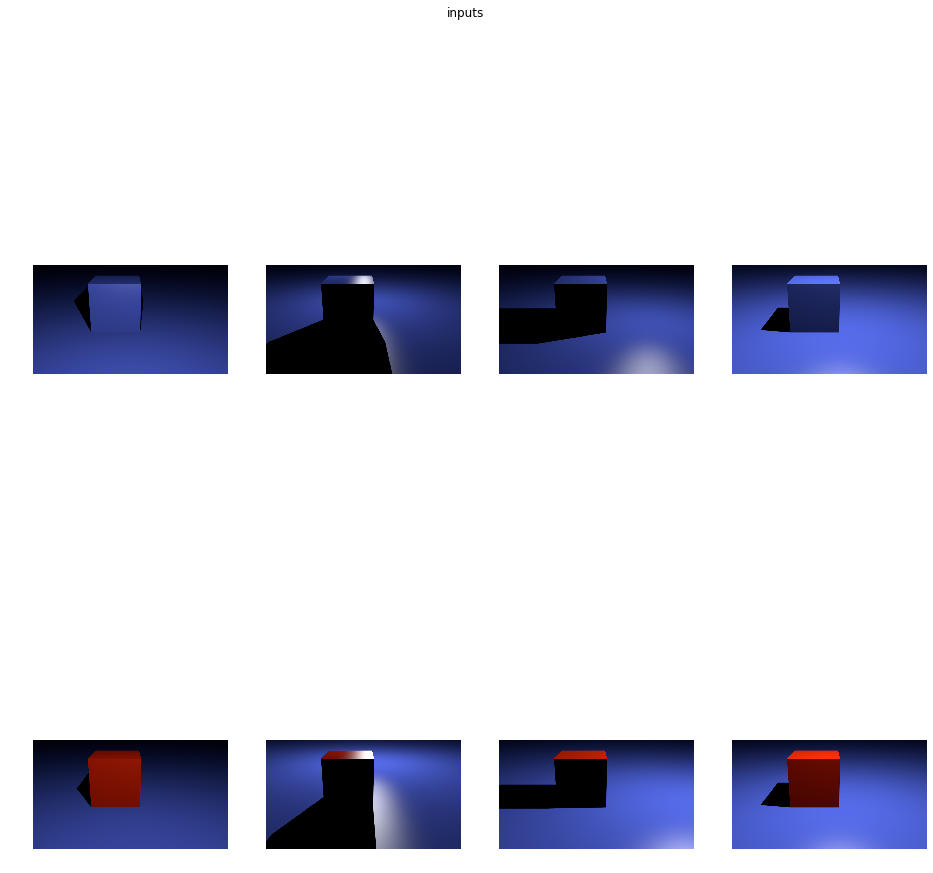

In [36]:
image_paths = [*sorted(glob.glob('images/long_range_perception/equal_color/*')), 
                          *sorted(glob.glob('images/long_range_perception/different_color/*'))]
               
image_paths = filter(lambda x: os.path.isfile(x), image_paths)

images = list(map(lambda x: Image.open(x).convert('RGB'), image_paths))

subplot(images, title='inputs', nrows=2, ncols=4)

plt.show()

There are four different lights configuration and two differents cube colors, one equal to the ground and the second different. The first column represents a realistic situation, while the second has a really strong light from behind that generates a shadow in front of the camera. The third column has a shadow on the left and the last one has a little shadow on the left. 

This is a perfect scenario to use gradcam to see what the model is looking in each image. In the picture below we plotted the gradcam results.

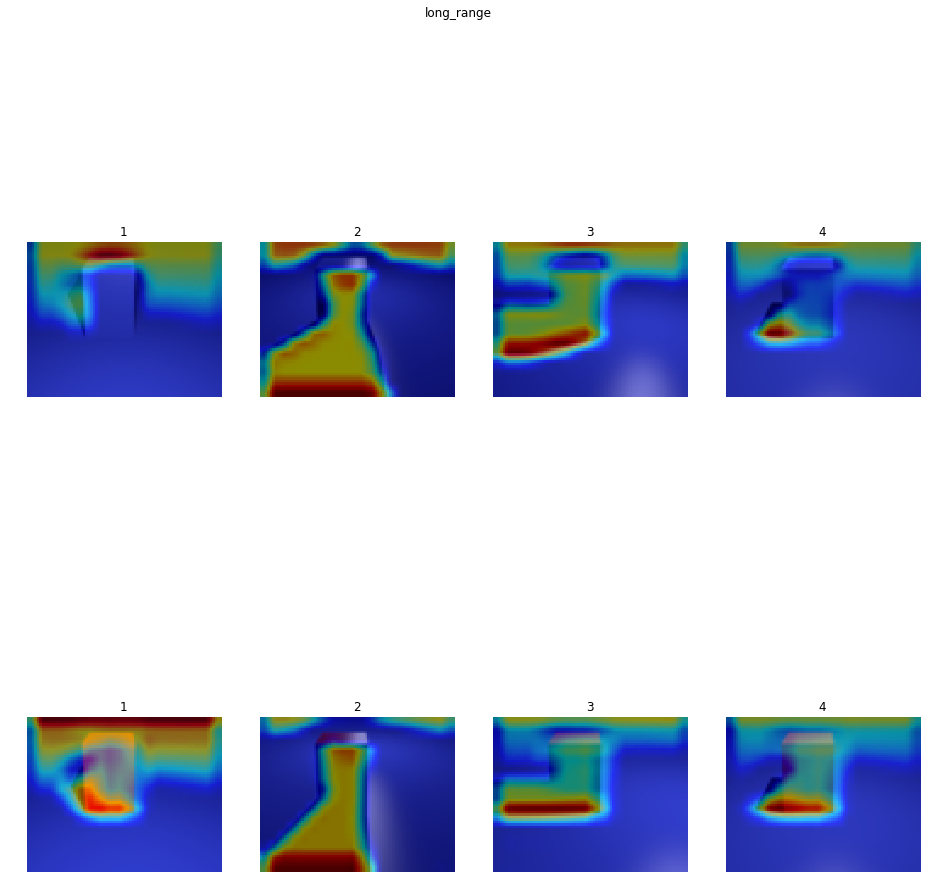

In [37]:
inputs  = [pre_processing(x).unsqueeze(0).to(device) for x in images]  # add 1 dim for batch


run_long_range_vis()

The big black shadow in the second column definitly confuses the model. In the first and last column, the grad cam highlights better the corners of the red cube, especially in the first picture. We can definitely say that this model has some hard time with the object of the same colour as the ground. Thanks to this consideration, we could improve the number equal object/ground in the dataset, perform a better preprocessing, change the model structure etc and hopefully increase the robustness of the network.

## Conclusion

In this article, we present different convolutional neural network visualization techniques. In the first section, we introduced each one by applying to a set of famous classification networks. We compared different networks on different inputs and highlight the similarities and difference between them. Then we apply them to a model adopted in robotics to test its robustness and we were able to successfully reveal a problem in the network.

Moreover, as a side project, I developed an interactive convolutional neural network visualization application called [mirro](https://github.com/FrancescoSaverioZuppichini/mirror) that receives in just a few days more than a hundred stars on GitHub reflecting the interest of the deep learning community on this topic.

 All these visualizations are implemented using a common interface and there are available as [python module](https://github.com/FrancescoSaverioZuppichini/A-journey-into-Convolutional-Neural-Network-visualization-/tree/master/visualisation) so they can be used in any other module.


Thank for reading

Francesco Saverio Zuppichini